# DLMI - Lymphocytosis classification
## One image one label models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import metrics, model_selection
from torch.utils.data import DataLoader

sys.path.append("../src/")
from utils import train, test, trainer
from one_image_one_label import (
    ImageLabelDataset, 
    ImageDataset, 
    image_to_numpy, 
    load_images, 
    assign_labels
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
data_dir = "../data/dlmi-lymphocytosis-classification/"
train_dir = data_dir + "trainset/"
test_dir = data_dir + "testset/"

In [4]:
train_images = load_images(train_dir)
test_images = load_images(test_dir)

../data/dlmi-lymphocytosis-classification/testset/P197/000034.jpg
(224, 224, 3)


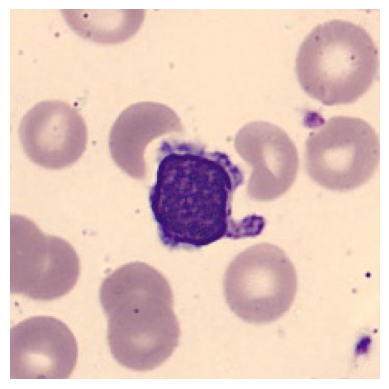

In [5]:
image_path = list(test_images.values())[5][10]
print(image_path)
image = image_to_numpy(image_path)
print(image.shape)
plt.imshow(image)
plt.axis("off")
plt.show()

In [6]:
trainset_true_df = pd.read_csv(data_dir + "trainset/trainset_true.csv")
labels_dict = dict(zip(trainset_true_df["ID"], trainset_true_df["LABEL"]))
X_train_val, y_train_val = assign_labels(train_images, labels_dict)
len(X_train_val), len(y_train_val)

(13453, 13453)

In [7]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size=0.25)
len(X_train), len(X_val)

(10089, 3364)

In [8]:
transform_function = lambda x: x.reshape(3, x.shape[0], x.shape[1])

In [9]:
batch_size = 32
train_dataset = ImageLabelDataset(X_train, y_train, transform_function)
test_dataset = ImageLabelDataset(X_val, y_val, transform_function)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Sequential(
                nn.Linear(12544, 2048),
                nn.ReLU(),
                nn.Linear(2048, 512),
                nn.ReLU(),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Linear(128, 32),
                nn.ReLU(),
                nn.Linear(32, 8),
                nn.ReLU(),
                nn.Linear(8, 2)
            )
        )

    def forward(self, x):
        return self.model(x)

In [11]:
model = CNN().to(device)
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
loss_fn = nn.CrossEntropyLoss()

n_epochs = 100
(train_losses, train_accuracies), (test_losses, test_accuracies) = trainer(
    model, optimizer, loss_fn, train_dataloader, test_dataloader, n_epochs
)

plt.figure()
plt.plot(train_accuracies, label="Train accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()